# TabPFN增强版：性早熟预测模型

**使用TabPFN 6.0.6 + Extensions 0.2.2 进行全方位优化**

本笔记本展示了TabPFN的多种增强技术：
- 基础TabPFN模型（**支持50000样本**、**KV Cache加速**、**概率校准**）
- 超参数优化（HPO）
- Post-hoc集成（AutoTabPFN）
- SHAP可解释性分析
- **PDP部分依赖图分析**（新功能）
- **ShapIQ特征交互分析**（新功能）
- 特征选择优化
- 改进的采样策略

## 1. 导入必要的库

In [1]:
# 设置环境变量
import os

os.environ["SCIPY_ARRAY_API"] = "1"

import pandas as pd
import numpy as np
import warnings
import joblib

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# TabPFN相关库
from tabpfn import TabPFNClassifier
from tabpfn_extensions.hpo import TunedTabPFNClassifier
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier
from tabpfn_extensions import interpretability
from tabpfn_extensions.embedding import TabPFNEmbedding

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

print("所有库导入完成")

所有库导入完成


## 2. 设置路径和参数

In [2]:
os.makedirs("./output", exist_ok=True)
os.makedirs("./output/models", exist_ok=True)
os.makedirs("./output/tabpfn_enhanced", exist_ok=True)
os.makedirs("./output/tabpfn_enhanced/models", exist_ok=True)

RANDOM_SEED = 825
np.random.seed(RANDOM_SEED)
N_JOBS = -1

print(f"随机种子设置: {RANDOM_SEED}")
print(f"输出目录: ./output/tabpfn_enhanced/")

随机种子设置: 825
输出目录: ./output/tabpfn_enhanced/


## 3. 读取数据

In [3]:
normal_data = pd.read_csv("./input/性早熟数据激发试验正常组_new.csv")
disease_data = pd.read_csv("./input/激发试验确诊性早熟组数据_new.csv")

normal_data["group"] = "N"
disease_data["group"] = "Y"

print(f"正常组: {normal_data.shape[0]} 行, 早熟组: {disease_data.shape[0]} 行")

正常组: 8970 行, 早熟组: 10654 行


## 4. 数据类型处理和合并

In [ ]:
# 分组填补：先对每组分别填补，再合并
exclude_cols = ["group", "患者编号", "Unnamed: 0"]
feature_cols = [col for col in normal_data.columns if col not in exclude_cols]

# 定义分类特征和数值特征
categorical_info = {
    "Tanner分期": (1, 5),
    "乳晕色素沉着": (0, 2),
    "乳核": (0, 1),
    "有无阴毛": (0, 1),
    "有无腋毛": (0, 1),
}
categorical_cols = [c for c in categorical_info.keys() if c in feature_cols]
numerical_cols = [c for c in feature_cols if c not in categorical_cols]

print(f"使用 {len(feature_cols)} 个特征")
print(f"分类特征 ({len(categorical_cols)}个): {categorical_cols}")
print(f"数值特征 ({len(numerical_cols)}个)")

# ===== 分组填补 =====
from sklearn.ensemble import RandomForestClassifier

print("\n使用MissForest方法进行分组填补...")

# 正常组填补器
cat_imputer_normal = IterativeImputer(
    estimator=RandomForestClassifier(
        n_estimators=10, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED
    ),
    max_iter=10,
    random_state=RANDOM_SEED,
    verbose=0,
)
num_imputer_normal = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=10, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED
    ),
    max_iter=10,
    random_state=RANDOM_SEED,
    verbose=0,
)

# 性早熟组填补器
cat_imputer_disease = IterativeImputer(
    estimator=RandomForestClassifier(
        n_estimators=10, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED
    ),
    max_iter=10,
    random_state=RANDOM_SEED,
    verbose=0,
)
num_imputer_disease = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=10, max_depth=10, n_jobs=-1, random_state=RANDOM_SEED
    ),
    max_iter=10,
    random_state=RANDOM_SEED,
    verbose=0,
)

# 正常组填补
normal_cat = (
    cat_imputer_normal.fit_transform(normal_data[categorical_cols])
    if categorical_cols
    else None
)
normal_num = num_imputer_normal.fit_transform(normal_data[numerical_cols])

# 性早熟组填补
disease_cat = (
    cat_imputer_disease.fit_transform(disease_data[categorical_cols])
    if categorical_cols
    else None
)
disease_num = num_imputer_disease.fit_transform(disease_data[numerical_cols])

# 裁剪分类特征到有效范围
if categorical_cols:
    for i, col in enumerate(categorical_cols):
        min_val, max_val = categorical_info[col]
        normal_cat[:, i] = normal_cat[:, i].clip(min_val, max_val)
        disease_cat[:, i] = disease_cat[:, i].clip(min_val, max_val)

# 组装填补后的数据
if categorical_cols:
    normal_imputed = pd.DataFrame(
        np.hstack([normal_cat, normal_num]), columns=categorical_cols + numerical_cols
    )
    disease_imputed = pd.DataFrame(
        np.hstack([disease_cat, disease_num]), columns=categorical_cols + numerical_cols
    )
else:
    normal_imputed = pd.DataFrame(normal_num, columns=numerical_cols)
    disease_imputed = pd.DataFrame(disease_num, columns=numerical_cols)

print(f"正常组填补完成: {normal_imputed.shape}")
print(f"性早熟组填补完成: {disease_imputed.shape}")

# 添加标签列
normal_imputed["group"] = "N"
disease_imputed["group"] = "Y"

# 合并数据
data = pd.concat([normal_imputed, disease_imputed], axis=0, ignore_index=True)
data["group"] = data["group"].astype("category")
print(f"\n合并后数据: {data.shape[0]} 行 x {data.shape[1]} 列")
print(f"分组统计:\n{data['group'].value_counts()}")

合并后数据: 19624 行 x 40 列
分组统计:
group
Y    10654
N     8970
Name: count, dtype: int64


## 5. 划分训练集和验证集

In [5]:
train_data, validation_data = train_test_split(
    data, test_size=0.3, stratify=data["group"], random_state=RANDOM_SEED
)

print(f"训练集: {train_data.shape[0]} 行, 验证集: {validation_data.shape[0]} 行")

训练集: 13736 行, 验证集: 5888 行


## 6. 特征工程

In [6]:
exclude_cols = ["group", "患者编号", "Unnamed: 0"]
feature_cols = [col for col in train_data.columns if col not in exclude_cols]

X_train = train_data[feature_cols].copy()
y_train = train_data["group"].copy()
X_validation = validation_data[feature_cols].copy()
y_validation = validation_data["group"].copy()

y_train_binary = (y_train == "Y").astype(int)
y_validation_binary = (y_validation == "Y").astype(int)

print(f"使用 {len(feature_cols)} 个特征")
print(f"训练集正负样本: {y_train_binary.value_counts().to_dict()}")
print(f"验证集正负样本: {y_validation_binary.value_counts().to_dict()}")

使用 38 个特征
训练集正负样本: {1: 7457, 0: 6279}
验证集正负样本: {1: 3197, 0: 2691}


## 7. 数据预处理（缺失值填充）

In [ ]:
# 数据已在分组填补阶段完成，这里只需准备特征
feature_cols_ordered = categorical_cols + numerical_cols

X_train_processed = train_data[feature_cols_ordered].values
X_validation_processed = validation_data[feature_cols_ordered].values

feature_cols_processed = feature_cols_ordered

print(f"\n预处理完成！")
print(f"  特征数: {X_train_processed.shape[1]}")
print(f"  训练集样本: {X_train_processed.shape[0]}")
print(f"  验证集样本: {X_validation_processed.shape[0]}")

数据预处理开始...
分类特征 (5个): ['Tanner分期', '乳晕色素沉着', '乳核', '有无阴毛', '有无腋毛']
数值特征 (33个)
使用 IterativeImputer + RandomForestClassifier 填补分类特征...
分类特征填补完成
使用MissForest方法填补数值特征...

预处理完成！
  原始特征数: 38
  处理后特征数: 38
  训练集样本: 13736
  验证集样本: 5888
  缺失值: 0 (应为0)


---
# 模型训练与优化

## 10. 准备训练数据（分层采样）

In [8]:
max_samples = 50000

if len(X_train_processed) > max_samples:
    print(f"训练集样本数({len(X_train_processed)})超过{max_samples}，进行分层采样")

    # 使用分层采样保持类别平衡
    sss = StratifiedShuffleSplit(
        n_splits=1, train_size=max_samples, random_state=RANDOM_SEED
    )
    for sample_idx, _ in sss.split(X_train_processed, y_train_binary):
        X_train_sampled = X_train_processed[sample_idx]
        y_train_sampled = y_train_binary.iloc[sample_idx].values

    print(f"采样后类别分布: {np.bincount(y_train_sampled)}")
else:
    X_train_sampled = X_train_processed
    y_train_sampled = y_train_binary.values
    print(f"使用{len(X_train_sampled)}个训练样本")

print(f"训练样本: {len(X_train_sampled)}, 特征数: {X_train_sampled.shape[1]}")

使用13736个训练样本
训练样本: 13736, 特征数: 38


## 11. 模型1：基础TabPFN

In [ ]:
print("=" * 70)
print("训练基础TabPFN模型")
print("=" * 70)
from tabpfn.inference_tuning import ClassifierTuningConfig

tabpfn_basic = TabPFNClassifier(
    n_estimators=32,
    device="cuda",
    random_state=RANDOM_SEED,
    eval_metric="f1",
    tuning_config=ClassifierTuningConfig(
        calibrate_temperature=True,
        tune_decision_thresholds=True,
    ),
)

print(f"  - 训练样本数: {len(X_train_sampled)}")
print("\n开始训练...")

tabpfn_basic.fit(X_train_sampled, y_train_sampled)

y_pred_basic = tabpfn_basic.predict(X_validation_processed)
y_pred_proba_basic = tabpfn_basic.predict_proba(X_validation_processed)[:, 1]

auc_basic = roc_auc_score(y_validation_binary, y_pred_proba_basic)
f1_basic = f1_score(y_validation_binary, y_pred_basic)
acc_basic = accuracy_score(y_validation_binary, y_pred_basic)

print(f"\n基础TabPFN性能 (带概率校准):")
print(f"  AUC: {auc_basic:.4f}")
print(f"  F1:  {f1_basic:.4f}")
print(f"  ACC: {acc_basic:.4f}")

# 保存模型
joblib.dump(
    {
        "model": tabpfn_basic,
        "cat_imputer_normal": cat_imputer_normal,
        "cat_imputer_disease": cat_imputer_disease,
        "num_imputer_normal": num_imputer_normal,
        "num_imputer_disease": num_imputer_disease,
        "categorical_cols": categorical_cols,
        "numerical_cols": numerical_cols,
    },
    "./output/tabpfn_enhanced/models/tabpfn_basic.pkl",
)
print(f"\n模型已保存: ./output/tabpfn_enhanced/models/tabpfn_basic.pkl")

训练基础TabPFN模型
  - 训练样本数: 13736

开始训练...

基础TabPFN性能 (带概率校准):
  AUC: 0.8845
  F1:  0.8332
  ACC: 0.8101

模型已保存: ./output/tabpfn_enhanced/models/tabpfn_basic.pkl


## 12. 模型2：超参数优化（HPO）

使用TunedTabPFNClassifier自动搜索最优超参数

In [ ]:
print("=" * 70)
print("训练HPO优化TabPFN模型")
print("=" * 70)

# 超参数优化
tabpfn_hpo = TunedTabPFNClassifier(
    n_trials=700,
    metric="f1",
    device="cuda",
    random_state=RANDOM_SEED,
    verbose=True,
)

print("开始超参数搜索...")
tabpfn_hpo.fit(X_train_sampled, y_train_sampled)

y_pred_hpo = tabpfn_hpo.predict(X_validation_processed)
y_pred_proba_hpo = tabpfn_hpo.predict_proba(X_validation_processed)[:, 1]

auc_hpo = roc_auc_score(y_validation_binary, y_pred_proba_hpo)
f1_hpo = f1_score(y_validation_binary, y_pred_hpo)
acc_hpo = accuracy_score(y_validation_binary, y_pred_hpo)

print(f"\nHPO优化TabPFN性能:")
print(f"  AUC: {auc_hpo:.4f}")
print(f"  F1:  {f1_hpo:.4f}")
print(f"  ACC: {acc_hpo:.4f}")

# 保存模型
joblib.dump(
    {
        "model": tabpfn_hpo,
        "cat_imputer_normal": cat_imputer_normal,
        "cat_imputer_disease": cat_imputer_disease,
        "num_imputer_normal": num_imputer_normal,
        "num_imputer_disease": num_imputer_disease,
        "categorical_cols": categorical_cols,
        "numerical_cols": numerical_cols,
    },
    "./output/tabpfn_enhanced/models/tabpfn_hpo.pkl",
)
print(f"\n模型已保存: ./output/tabpfn_enhanced/models/tabpfn_hpo.pkl")

## 13. 模型3：Post-hoc集成（AutoTabPFN）

自动训练和集成多个TabPFN配置

In [ ]:
print("=" * 70)
print("训练Post-hoc集成TabPFN模型")
print("=" * 70)

# 检查GPU状态
import torch

print(f"PyTorch CUDA 可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU 设备: {torch.cuda.get_device_name(0)}")
    print(f"CUDA 设备数量: {torch.cuda.device_count()}")
else:
    raise RuntimeError("CUDA 不可用，无法继续")

# 检查Ray版本
import ray

print(f"Ray 版本: {ray.__version__}")


# Post-hoc集成
tabpfn_auto = AutoTabPFNClassifier(
    max_time=12600,  # 3.5h
    presets="best_quality",
    device="cuda:0",
    ignore_pretraining_limits=True,
)

print("模型初始化成功")
print("使用设备: cuda:0")
print(f"训练样本数: {len(X_train_sampled)} (已启用ignore_pretraining_limits)")
print("开始自动集成训练...")
print("(这可能需要较长时间，正在训练多个模型配置...)")

tabpfn_auto.fit(X_train_sampled, y_train_sampled)

y_pred_auto = tabpfn_auto.predict(X_validation_processed)
y_pred_proba_auto = tabpfn_auto.predict_proba(X_validation_processed)[:, 1]

auc_auto = roc_auc_score(y_validation_binary, y_pred_proba_auto)
f1_auto = f1_score(y_validation_binary, y_pred_auto)
acc_auto = accuracy_score(y_validation_binary, y_pred_auto)

print(f"\nPost-hoc集成TabPFN性能:")
print(f"  AUC: {auc_auto:.4f}")
print(f"  F1:  {f1_auto:.4f}")
print(f"  ACC: {acc_auto:.4f}")

# 保存模型
joblib.dump(
    {
        "model": tabpfn_auto,
        "cat_imputer_normal": cat_imputer_normal,
        "cat_imputer_disease": cat_imputer_disease,
        "num_imputer_normal": num_imputer_normal,
        "num_imputer_disease": num_imputer_disease,
        "categorical_cols": categorical_cols,
        "numerical_cols": numerical_cols,
    },
    "./output/tabpfn_enhanced/models/tabpfn_auto.pkl",
)
print(f"\n模型已保存: ./output/tabpfn_enhanced/models/tabpfn_auto.pkl")

		scikit-learn estimators should always specify their parameters in the signature of their __init__ (no varargs). <class 'tabpfn.preprocessors.kdi_transformer.KDITransformerWithNaN'> with constructor (self, *args: 'Any', **kwargs: 'Any') -> 'None' doesn't  follow this convention.
Detailed Traceback:
Traceback (most recent call last):
  File "d:\anaconda3\envs\PPML\Lib\site-packages\autogluon\tabular\trainer\abstract_trainer.py", line 2171, in _train_and_save
    model = self._train_single(**model_fit_kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\PPML\Lib\site-packages\autogluon\tabular\trainer\abstract_trainer.py", line 2055, in _train_single
    model = model.fit(X=X, y=y, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test, total_resources=total_resources, **model_fit_kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\PP


Post-hoc集成TabPFN性能:
  AUC: 0.8830
  F1:  0.8273
  ACC: 0.8088

模型已保存: ./output/tabpfn_enhanced/models/tabpfn_auto.pkl


## 14. 无监督学习：异常检测（Unsupervised）

使用TabPFN进行异常样本检测

TabPFN嵌入提取分析
提取TabPFN内部嵌入表示...

提取训练集嵌入...
提取验证集嵌入...
嵌入维度: (13736, 192)

基于TabPFN嵌入的逻辑回归性能:
  AUC: 0.8818
  F1:  0.8104
  ACC: 0.7498


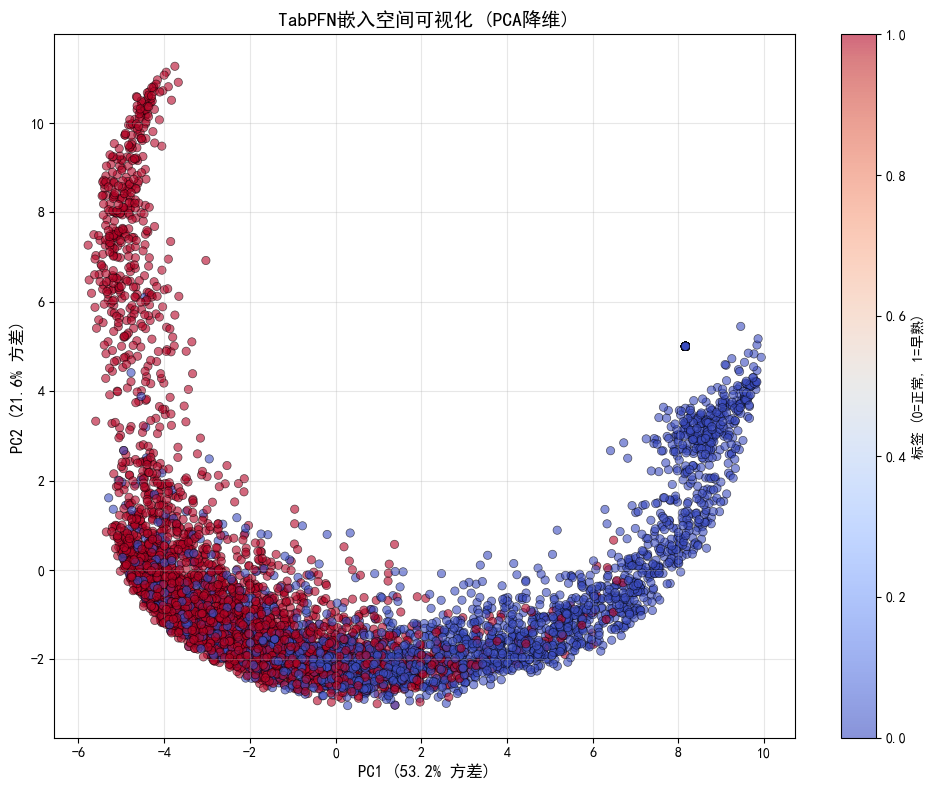


嵌入空间可视化已保存
嵌入数据已保存


In [13]:
print("=" * 70)
print("TabPFN嵌入提取分析")
print("=" * 70)

print("提取TabPFN内部嵌入表示...\n")

# 使用已训练的基础TabPFN模型作为嵌入提取器
embedding_extractor = TabPFNEmbedding(tabpfn_clf=tabpfn_basic, n_fold=0)

# 提取训练集嵌入
print("提取训练集嵌入...")
train_embeddings = embedding_extractor.get_embeddings(
    X_train_sampled, y_train_sampled, X_train_sampled, data_source="train"
)

# 提取验证集嵌入
print("提取验证集嵌入...")
val_embeddings = embedding_extractor.get_embeddings(
    X_train_sampled, y_train_sampled, X_validation_processed, data_source="test"
)

print(f"嵌入维度: {train_embeddings[0].shape}")

# 使用嵌入训练逻辑回归
from sklearn.linear_model import LogisticRegression

embedding_model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
embedding_model.fit(train_embeddings[0], y_train_sampled)

y_pred_embedding = embedding_model.predict(val_embeddings[0])
y_pred_proba_embedding = embedding_model.predict_proba(val_embeddings[0])[:, 1]

auc_embedding = roc_auc_score(y_validation_binary, y_pred_proba_embedding)
f1_embedding = f1_score(y_validation_binary, y_pred_embedding)
acc_embedding = accuracy_score(y_validation_binary, y_pred_embedding)

print(f"\n基于TabPFN嵌入的逻辑回归性能:")
print(f"  AUC: {auc_embedding:.4f}")
print(f"  F1:  {f1_embedding:.4f}")
print(f"  ACC: {acc_embedding:.4f}")

# 可视化嵌入空间（使用PCA降维）
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
val_embeddings_2d = pca.fit_transform(val_embeddings[0])

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    val_embeddings_2d[:, 0],
    val_embeddings_2d[:, 1],
    c=y_validation_binary,
    cmap="coolwarm",
    alpha=0.6,
    edgecolors="k",
    linewidth=0.5,
)
plt.colorbar(scatter, label="标签 (0=正常, 1=早熟)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} 方差)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} 方差)", fontsize=12)
plt.title("TabPFN嵌入空间可视化 (PCA降维)", fontsize=14, fontweight="bold")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(
    "./output/tabpfn_enhanced/TabPFN嵌入可视化.png", dpi=300, bbox_inches="tight"
)
plt.savefig(
    "./output/tabpfn_enhanced/TabPFN嵌入可视化.pdf", dpi=300, bbox_inches="tight"
)
plt.show()

print(f"\n嵌入空间可视化已保存")

# 保存嵌入
np.save("./output/tabpfn_enhanced/train_embeddings.npy", train_embeddings[0])
np.save("./output/tabpfn_enhanced/val_embeddings.npy", val_embeddings[0])
print("嵌入数据已保存")

### *导入模型文件

In [14]:
print("=" * 70)
print("导入已训练的模型并计算性能")
print("=" * 70)

import os
import joblib

# 模型文件路径
model_files = {
    "基础TabPFN": "./output/tabpfn_enhanced/models/tabpfn_basic.pkl",
    "HPO优化TabPFN": "./output/tabpfn_enhanced/models/tabpfn_hpo.pkl",
    "Post-hoc集成TabPFN": "./output/tabpfn_enhanced/models/tabpfn_auto.pkl",
}

# 导入模型
loaded_models = {}
for model_name, file_path in model_files.items():
    if os.path.exists(file_path):
        loaded_models[model_name] = joblib.load(file_path)

print(f"成功导入 {len(loaded_models)} 个模型")

# 计算性能
if loaded_models:
    # 提取模型
    tabpfn_basic = loaded_models["基础TabPFN"]["model"]
    tabpfn_hpo = loaded_models["HPO优化TabPFN"]["model"]
    tabpfn_auto = loaded_models["Post-hoc集成TabPFN"]["model"]
    imputer = loaded_models["基础TabPFN"]["imputer"]

    # 基础TabPFN
    y_pred_basic = tabpfn_basic.predict(X_validation_processed)
    y_pred_proba_basic = tabpfn_basic.predict_proba(X_validation_processed)[:, 1]
    auc_basic = roc_auc_score(y_validation_binary, y_pred_proba_basic)
    f1_basic = f1_score(y_validation_binary, y_pred_basic)
    acc_basic = accuracy_score(y_validation_binary, y_pred_basic)

    # HPO优化TabPFN
    y_pred_hpo = tabpfn_hpo.predict(X_validation_processed)
    y_pred_proba_hpo = tabpfn_hpo.predict_proba(X_validation_processed)[:, 1]
    auc_hpo = roc_auc_score(y_validation_binary, y_pred_proba_hpo)
    f1_hpo = f1_score(y_validation_binary, y_pred_hpo)
    acc_hpo = accuracy_score(y_validation_binary, y_pred_hpo)

    # Post-hoc集成TabPFN
    y_pred_auto = tabpfn_auto.predict(X_validation_processed)
    y_pred_proba_auto = tabpfn_auto.predict_proba(X_validation_processed)[:, 1]
    auc_auto = roc_auc_score(y_validation_binary, y_pred_proba_auto)
    f1_auto = f1_score(y_validation_binary, y_pred_auto)
    acc_auto = accuracy_score(y_validation_binary, y_pred_auto)

    # 打印性能对比
    print("\n模型性能对比：")
    print(
        f"  基础TabPFN:      F1={f1_basic:.4f}  AUC={auc_basic:.4f}  ACC={acc_basic:.4f}"
    )
    print(
        f"  HPO优化:         F1={f1_hpo:.4f}  AUC={auc_hpo:.4f}  ACC={acc_hpo:.4f}  ({f1_hpo-f1_basic:+.4f})"
    )
    print(
        f"  Post-hoc集成:    F1={f1_auto:.4f}  AUC={auc_auto:.4f}  ACC={acc_auto:.4f}  ({f1_auto-f1_basic:+.4f})"
    )

    print("\n性能计算完成，变量已就绪")
else:
    print("\n未导入任何模型")

导入已训练的模型并计算性能
成功导入 3 个模型

模型性能对比：
  基础TabPFN:      F1=0.8332  AUC=0.8845  ACC=0.8101
  HPO优化:         F1=0.8308  AUC=0.8832  ACC=0.8067  (-0.0025)
  Post-hoc集成:    F1=0.8273  AUC=0.8830  ACC=0.8088  (-0.0059)

性能计算完成，变量已就绪


## 15.性能对比

In [15]:
# 创建性能对比表
models_list = [
    ("基础TabPFN", auc_basic, f1_basic, acc_basic),
    ("HPO优化TabPFN", auc_hpo, f1_hpo, acc_hpo),
    ("Post-hoc集成TabPFN", auc_auto, f1_auto, acc_auto),
]

performance_summary = pd.DataFrame(models_list, columns=["模型", "AUC", "F1", "准确率"])
# 按F1分数排序（从高到低）
performance_summary = performance_summary.sort_values("F1", ascending=False)

print("\n" + "=" * 70)
print("TabPFN模型性能对比（以F1分数为准）")
print("=" * 70)
print(performance_summary.to_string(index=False))
print("=" * 70)

best_model_name = performance_summary.iloc[0]["模型"]
best_f1 = performance_summary.iloc[0]["F1"]
best_auc = performance_summary.iloc[0]["AUC"]
f1_improvement = (best_f1 - f1_basic) * 100

print(f"\n最佳模型: {best_model_name}")
print(f"   F1:  {best_f1:.4f} (相比基础模型: {f1_improvement:+.2f}%)")
print(f"   AUC: {best_auc:.4f}")
print(f"   ACC: {performance_summary.iloc[0]['准确率']:.4f}")

# 保存性能对比
performance_summary.to_csv(
    "./output/tabpfn_enhanced/性能对比.csv", index=False, encoding="utf-8-sig"
)
print(f"\n性能对比已保存: ./output/tabpfn_enhanced/性能对比.csv")


TabPFN模型性能对比（以F1分数为准）
              模型      AUC       F1      准确率
        基础TabPFN 0.884495 0.833234 0.810122
     HPO优化TabPFN 0.883168 0.830756 0.806726
Post-hoc集成TabPFN 0.883022 0.827301 0.808764

最佳模型: 基础TabPFN
   F1:  0.8332 (相比基础模型: +0.00%)
   AUC: 0.8845
   ACC: 0.8101

性能对比已保存: ./output/tabpfn_enhanced/性能对比.csv


## 16. ROC曲线

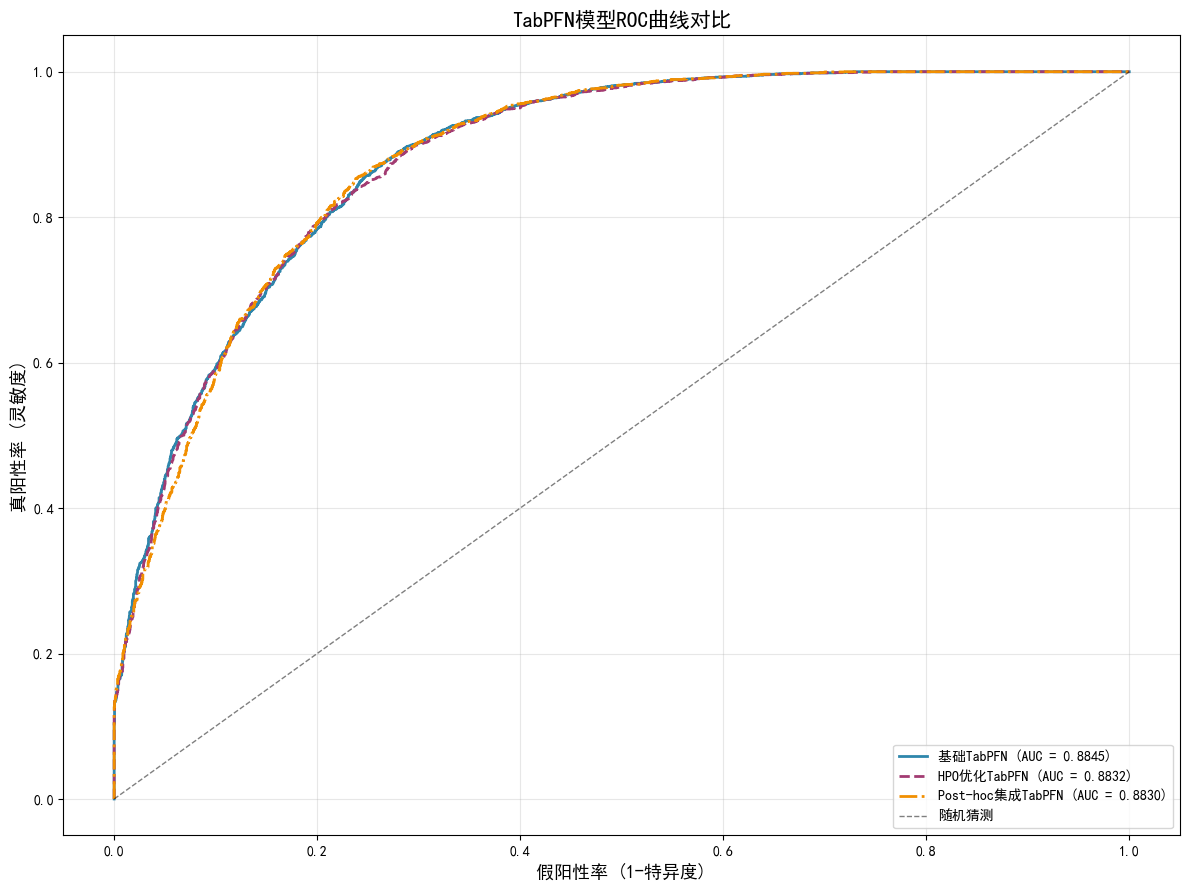

ROC曲线对比已保存


In [16]:
plt.figure(figsize=(12, 9))

# 基础TabPFN
fpr_basic, tpr_basic, _ = roc_curve(y_validation_binary, y_pred_proba_basic)
plt.plot(
    fpr_basic,
    tpr_basic,
    label=f"基础TabPFN (AUC = {auc_basic:.4f})",
    linewidth=2,
    color="#2E86AB",
    linestyle="-",
)

# HPO优化TabPFN
fpr_hpo, tpr_hpo, _ = roc_curve(y_validation_binary, y_pred_proba_hpo)
plt.plot(
    fpr_hpo,
    tpr_hpo,
    label=f"HPO优化TabPFN (AUC = {auc_hpo:.4f})",
    linewidth=2,
    color="#A23B72",
    linestyle="--",
)

# Post-hoc集成TabPFN
fpr_auto, tpr_auto, _ = roc_curve(y_validation_binary, y_pred_proba_auto)
plt.plot(
    fpr_auto,
    tpr_auto,
    label=f"Post-hoc集成TabPFN (AUC = {auc_auto:.4f})",
    linewidth=2,
    color="#F18F01",
    linestyle="-.",
)

# 随机猜测基线
plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="随机猜测", alpha=0.5)

plt.xlabel("假阳性率 (1-特异度)", fontsize=13)
plt.ylabel("真阳性率 (灵敏度)", fontsize=13)
plt.title("TabPFN模型ROC曲线对比", fontsize=15, fontweight="bold")
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig("./output/tabpfn_enhanced/ROC曲线对比.pdf", dpi=300, bbox_inches="tight")
plt.savefig("./output/tabpfn_enhanced/ROC曲线对比.png", dpi=300, bbox_inches="tight")
plt.show()

print("ROC曲线对比已保存")

## 17. 详细性能指标对比

In [17]:
# 为所有模型计算详细指标
models_results = {
    "基础TabPFN": (y_pred_basic, y_pred_proba_basic),
    "HPO优化TabPFN": (y_pred_hpo, y_pred_proba_hpo),
    "Post-hoc集成TabPFN": (y_pred_auto, y_pred_proba_auto),
}

detailed_metrics = []

for model_name, (y_pred, y_pred_proba) in models_results.items():
    cm = confusion_matrix(y_validation_binary, y_pred)

    accuracy = accuracy_score(y_validation_binary, y_pred)
    precision = precision_score(y_validation_binary, y_pred)
    recall = recall_score(y_validation_binary, y_pred)
    f1 = f1_score(y_validation_binary, y_pred)
    auc = roc_auc_score(y_validation_binary, y_pred_proba)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    detailed_metrics.append(
        {
            "模型": model_name,
            "AUC": auc,
            "准确率": accuracy,
            "精确率": precision,
            "召回率": recall,
            "特异度": specificity,
            "F1分数": f1,
        }
    )

    print(f"\n{'='*70}")
    print(f"{model_name} 详细指标")
    print(f"{'='*70}")
    print(f"混淆矩阵:")
    print(cm)
    print(f"TN={cm[0,0]}, FP={cm[0,1]}, FN={cm[1,0]}, TP={cm[1,1]}")
    print(f"\n准确率: {accuracy:.4f}")
    print(f"精确率: {precision:.4f}")
    print(f"召回率: {recall:.4f}")
    print(f"特异度: {specificity:.4f}")
    print(f"F1分数: {f1:.4f}")
    print(f"AUC:    {auc:.4f}")

# 保存详细指标
detailed_df = pd.DataFrame(detailed_metrics)
detailed_df = detailed_df.sort_values("F1分数", ascending=False)
detailed_df.to_csv(
    "./output/tabpfn_enhanced/详细性能指标.csv", index=False, encoding="utf-8-sig"
)

print(f"\n\n{'='*70}")
print("所有模型详细指标汇总")
print(f"{'='*70}")
print(detailed_df.to_string(index=False))
print(f"\n详细性能指标已保存: ./output/tabpfn_enhanced/详细性能指标.csv")


基础TabPFN 详细指标
混淆矩阵:
[[1977  714]
 [ 404 2793]]
TN=1977, FP=714, FN=404, TP=2793

准确率: 0.8101
精确率: 0.7964
召回率: 0.8736
特异度: 0.7347
F1分数: 0.8332
AUC:    0.8845

HPO优化TabPFN 详细指标
混淆矩阵:
[[1957  734]
 [ 404 2793]]
TN=1957, FP=734, FN=404, TP=2793

准确率: 0.8067
精确率: 0.7919
召回率: 0.8736
特异度: 0.7272
F1分数: 0.8308
AUC:    0.8832

Post-hoc集成TabPFN 详细指标
混淆矩阵:
[[2065  626]
 [ 500 2697]]
TN=2065, FP=626, FN=500, TP=2697

准确率: 0.8088
精确率: 0.8116
召回率: 0.8436
特异度: 0.7674
F1分数: 0.8273
AUC:    0.8830


所有模型详细指标汇总
              模型      AUC      准确率      精确率      召回率      特异度     F1分数
        基础TabPFN 0.884495 0.810122 0.796407 0.873632 0.734671 0.833234
     HPO优化TabPFN 0.883168 0.806726 0.791891 0.873632 0.727239 0.830756
Post-hoc集成TabPFN 0.883022 0.808764 0.811616 0.843603 0.767373 0.827301

详细性能指标已保存: ./output/tabpfn_enhanced/详细性能指标.csv


## 18. 预测概率分布对比

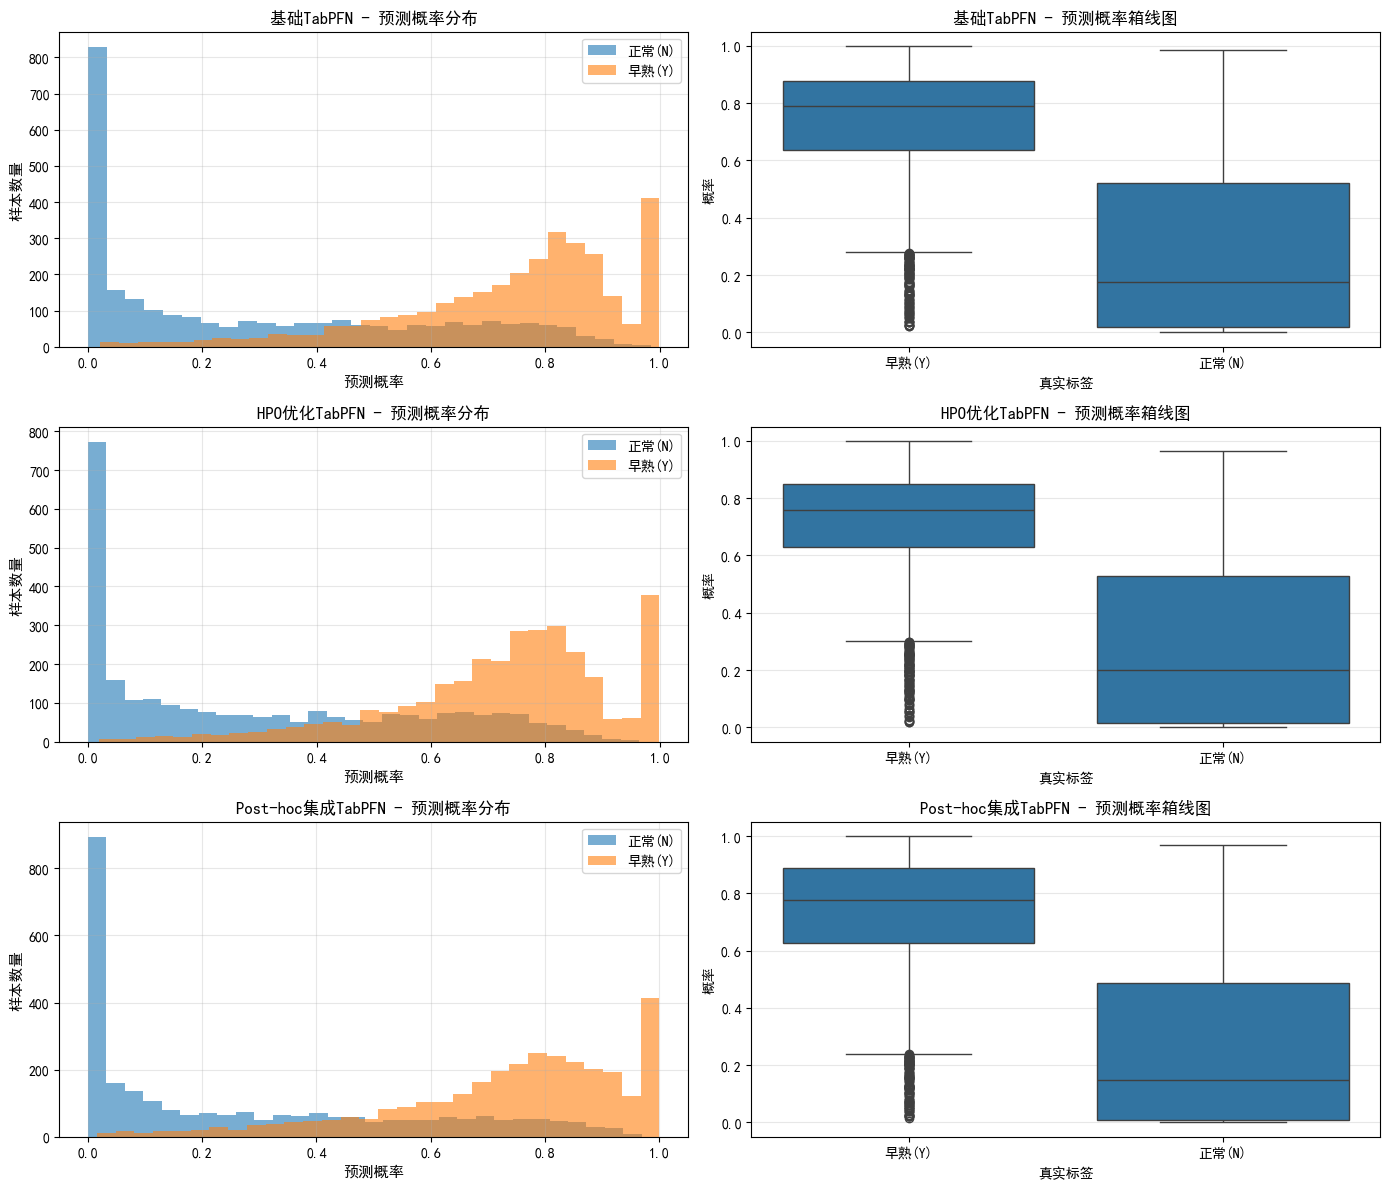

预测概率分布对比图已保存


In [18]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

models_plot = [
    ("基础TabPFN", y_pred_proba_basic),
    ("HPO优化TabPFN", y_pred_proba_hpo),
    ("Post-hoc集成TabPFN", y_pred_proba_auto),
]

for idx, (model_name, y_pred_proba) in enumerate(models_plot):
    # 概率分布直方图
    ax1 = axes[idx, 0]
    for label, name in [(0, "正常(N)"), (1, "早熟(Y)")]:
        mask = y_validation_binary == label
        ax1.hist(y_pred_proba[mask], bins=30, alpha=0.6, label=name)
    ax1.set_xlabel("预测概率", fontsize=11)
    ax1.set_ylabel("样本数量", fontsize=11)
    ax1.set_title(f"{model_name} - 预测概率分布", fontsize=12, fontweight="bold")
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 概率箱线图
    ax2 = axes[idx, 1]
    data_plot = pd.DataFrame(
        {
            "概率": y_pred_proba,
            "真实标签": [
                "正常(N)" if y == 0 else "早熟(Y)" for y in y_validation_binary
            ],
        }
    )
    sns.boxplot(data=data_plot, x="真实标签", y="概率", ax=ax2)
    ax2.set_title(f"{model_name} - 预测概率箱线图", fontsize=12, fontweight="bold")
    ax2.grid(alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig(
    "./output/tabpfn_enhanced/预测概率分布对比.pdf", dpi=300, bbox_inches="tight"
)
plt.savefig(
    "./output/tabpfn_enhanced/预测概率分布对比.png", dpi=300, bbox_inches="tight"
)
plt.show()

print("预测概率分布对比图已保存")

In [19]:
# 保存所有模型的预测结果
predictions_dict = {
    "真实标签": y_validation_binary,
    "基础TabPFN_预测": y_pred_basic,
    "基础TabPFN_概率": y_pred_proba_basic,
    "HPO优化TabPFN_预测": y_pred_hpo,
    "HPO优化TabPFN_概率": y_pred_proba_hpo,
    "Post-hoc集成TabPFN_预测": y_pred_auto,
    "Post-hoc集成TabPFN_概率": y_pred_proba_auto,
}

# 添加嵌入模型结果（如果可用）
if auc_embedding is not None:
    predictions_dict["TabPFN嵌入_预测"] = y_pred_embedding
    predictions_dict["TabPFN嵌入_概率"] = y_pred_proba_embedding

predictions_df = pd.DataFrame(predictions_dict)

predictions_df.to_csv(
    "./output/tabpfn_enhanced/验证集预测结果_完整版.csv",
    index=False,
    encoding="utf-8-sig",
)
print(f"预测结果已保存: ./output/tabpfn_enhanced/验证集预测结果_完整版.csv")
print(f"   验证集共 {len(predictions_df)} 样本")

预测结果已保存: ./output/tabpfn_enhanced/验证集预测结果_完整版.csv
   验证集共 5888 样本


In [20]:
# 保存所有模型的预测结果
predictions_df = pd.DataFrame(
    {
        "真实标签": y_validation_binary,
        "基础TabPFN_预测": y_pred_basic,
        "基础TabPFN_概率": y_pred_proba_basic,
        "HPO优化TabPFN_预测": y_pred_hpo,
        "HPO优化TabPFN_概率": y_pred_proba_hpo,
        "Post-hoc集成TabPFN_预测": y_pred_auto,
        "Post-hoc集成TabPFN_概率": y_pred_proba_auto,
    }
)

predictions_df.to_csv(
    "./output/tabpfn_enhanced/验证集预测结果.csv", index=False, encoding="utf-8-sig"
)
print(f"预测结果已保存: ./output/tabpfn_enhanced/验证集预测结果.csv")
print(f"   验证集共 {len(predictions_df)} 样本")

预测结果已保存: ./output/tabpfn_enhanced/验证集预测结果.csv
   验证集共 5888 样本


## 19. 性能提升总结

In [21]:
print("\n" + "=" * 70)
print("性能提升总结")
print("=" * 70)

# 计算相对于基础模型的提升
improvements = pd.DataFrame(
    {
        "模型": ["HPO优化TabPFN", "Post-hoc集成TabPFN"],
        "AUC提升(%)": [(auc_hpo - auc_basic) * 100, (auc_auto - auc_basic) * 100],
        "F1提升(%)": [(f1_hpo - f1_basic) * 100, (f1_auto - f1_basic) * 100],
        "准确率提升(%)": [(acc_hpo - acc_basic) * 100, (acc_auto - acc_basic) * 100],
    }
)

print(improvements.to_string(index=False))

print(f"\n基础模型:")
print(f"  AUC: {auc_basic:.4f}")
print(f"  F1:  {f1_basic:.4f}")
print(f"  ACC: {acc_basic:.4f}")

print(f"\n最佳模型: {best_model_name}")
print(f"  AUC: {best_auc:.4f} ({(best_auc - auc_basic)*100:+.2f}%)")
print(
    f"  F1:  {performance_summary.iloc[0]['F1']:.4f} ({(performance_summary.iloc[0]['F1'] - f1_basic)*100:+.2f}%)"
)
print(
    f"  ACC: {performance_summary.iloc[0]['准确率']:.4f} ({(performance_summary.iloc[0]['准确率'] - acc_basic)*100:+.2f}%)"
)

print("\n" + "=" * 70)


性能提升总结
              模型  AUC提升(%)   F1提升(%)  准确率提升(%)
     HPO优化TabPFN -0.132725 -0.247839 -0.339674
Post-hoc集成TabPFN -0.147289 -0.593328 -0.135870

基础模型:
  AUC: 0.8845
  F1:  0.8332
  ACC: 0.8101

最佳模型: 基础TabPFN
  AUC: 0.8845 (+0.00%)
  F1:  0.8332 (+0.00%)
  ACC: 0.8101 (+0.00%)



## 20. SHAP

SHAP可解释性分析 (KernelSHAP)
使用模型: 基础TabPFN
F1分数: 0.8332

背景样本: 100, 待解释样本: 100


  0%|          | 0/100 [00:00<?, ?it/s]

SHAP值计算完成！形状: (100, 38)

生成SHAP可视化图表

1. 生成 SHAP Summary Plot (Beeswarm)...


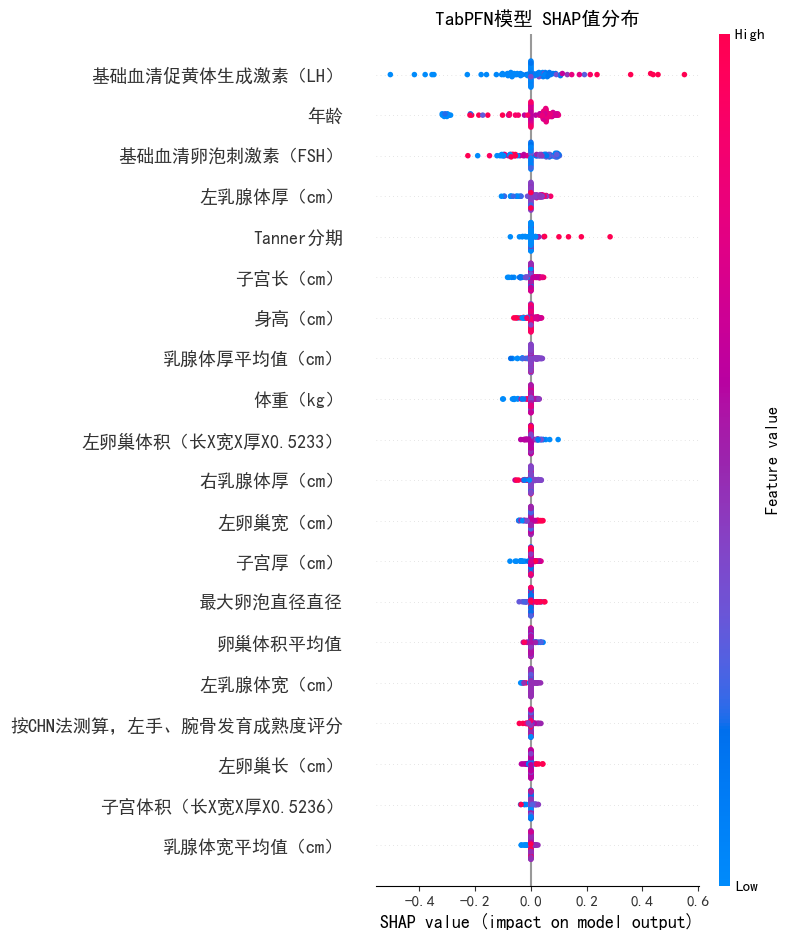

已保存: SHAP_summary_beeswarm.png/pdf

2. 生成 SHAP Bar Plot...


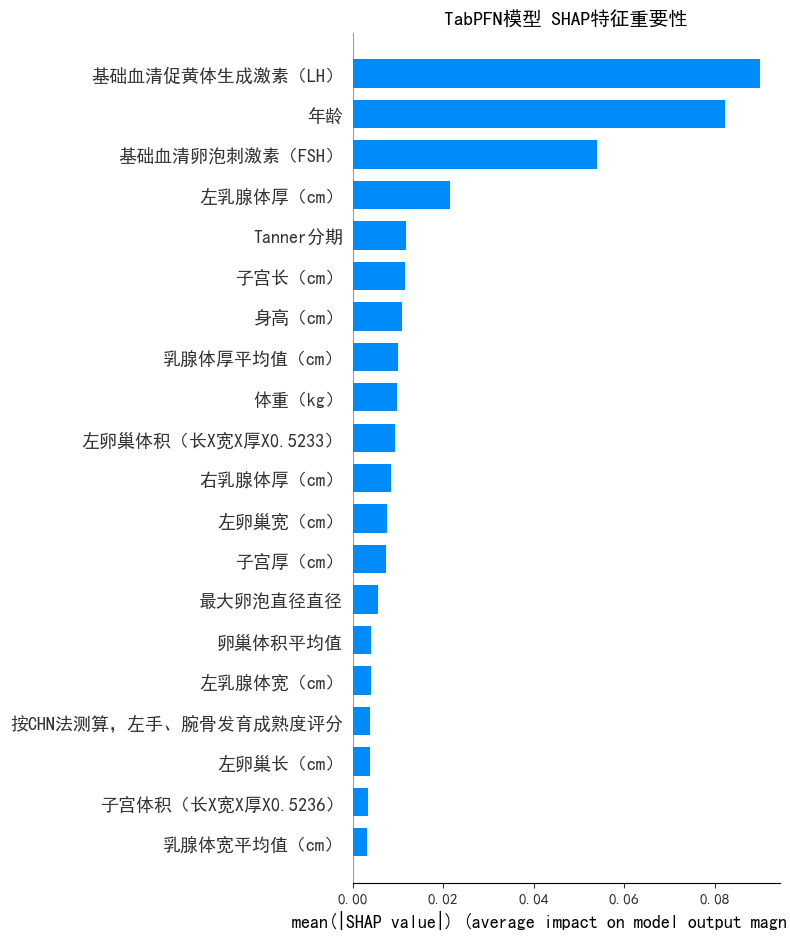


前15个最重要特征:
                 特征  SHAP重要性
    基础血清促黄体生成激素（LH） 0.089961
                 年龄 0.082348
     基础血清卵泡刺激素（FSH） 0.053950
          左乳腺体厚（cm） 0.021472
           Tanner分期 0.011815
            子宫长（cm） 0.011474
             身高（cm） 0.010871
        乳腺体厚平均值（cm） 0.010070
             体重（kg） 0.009679
左卵巢体积（长X宽X厚X0.5233） 0.009323
          右乳腺体厚（cm） 0.008450
           左卵巢宽（cm） 0.007559
            子宫厚（cm） 0.007404
           最大卵泡直径直径 0.005668
            卵巢体积平均值 0.004100

3. 生成 SHAP Dependence Plots...


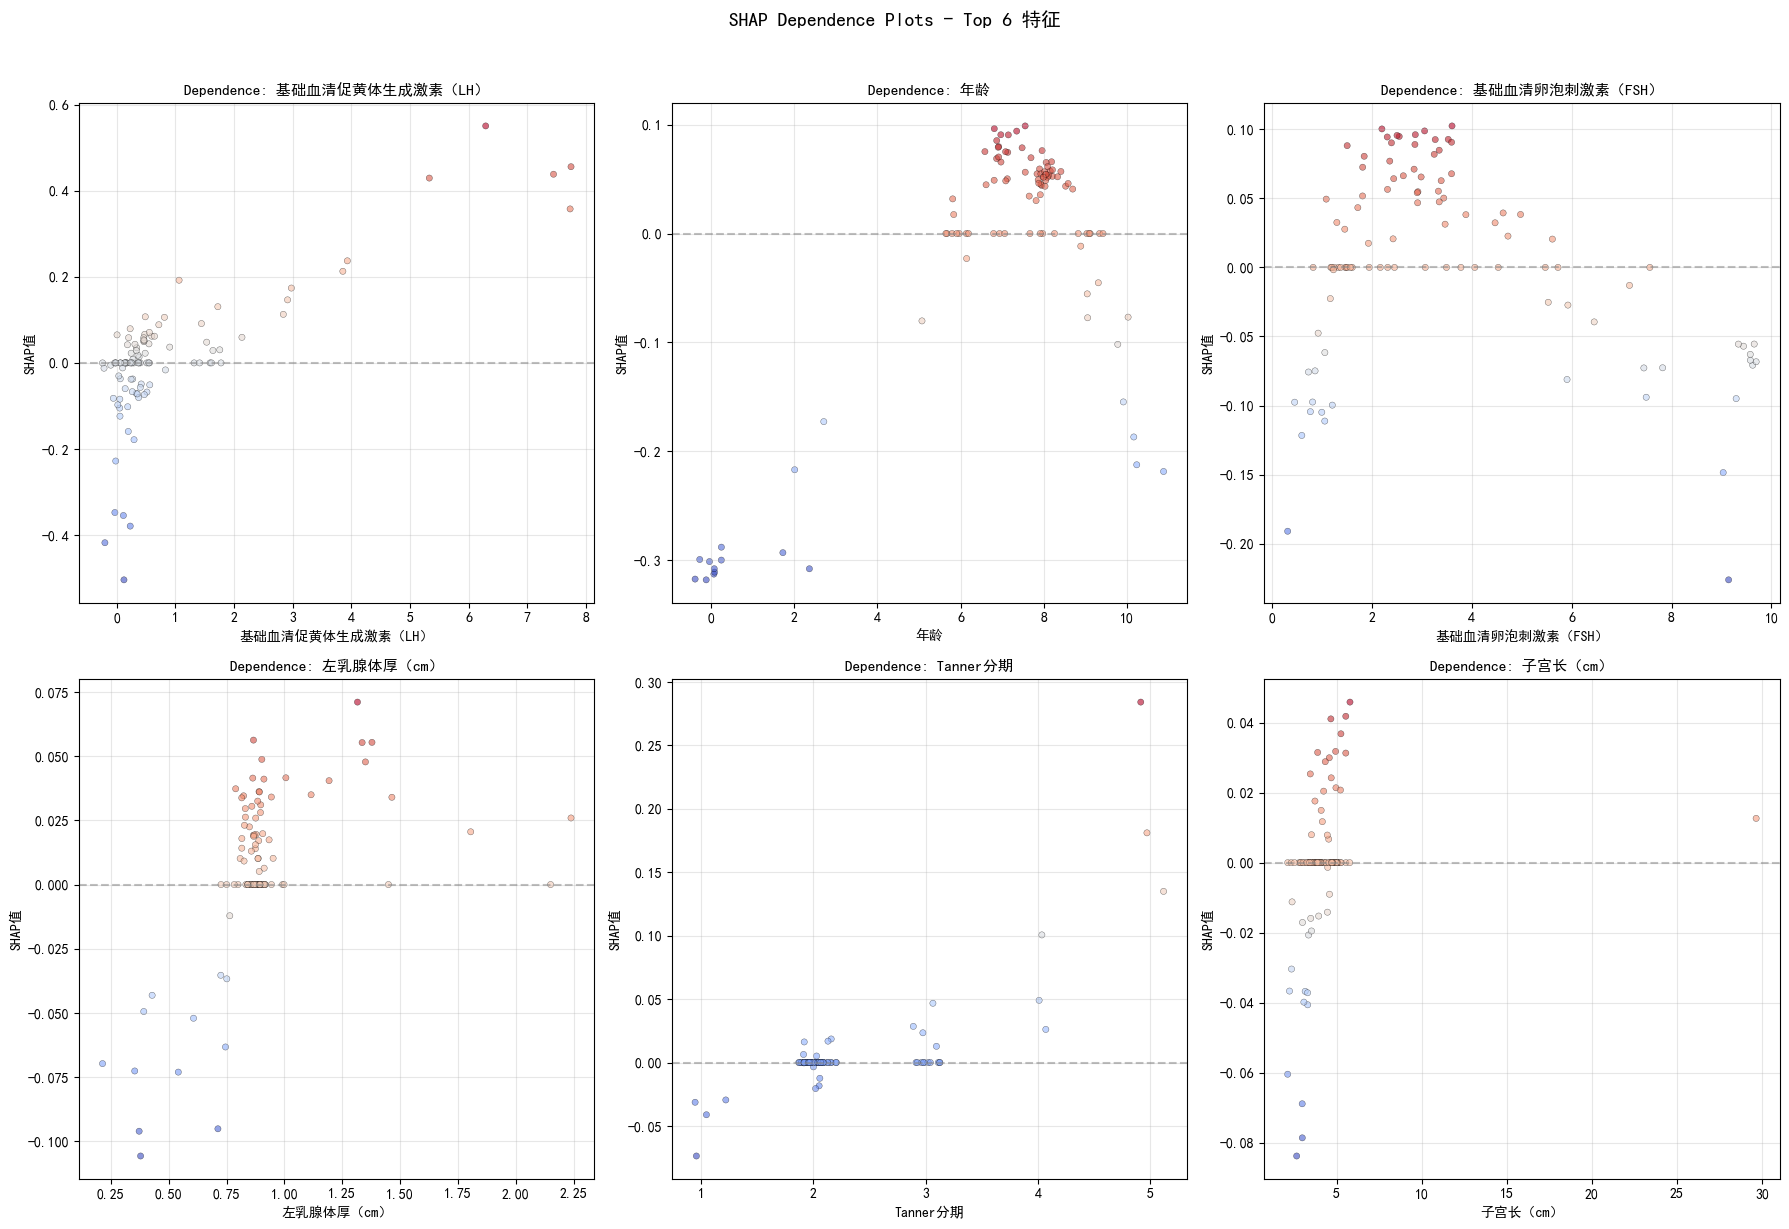

已保存: SHAP_dependence_top6.png/pdf

SHAP分析完成 (KernelSHAP)
生成的图表：
   1. SHAP_summary_beeswarm.png - 特征影响分布图
   2. SHAP_bar_importance.png - 特征重要性条形图
   3. SHAP_dependence_top6.png - Top6特征依赖图
   4. SHAP_feature_importance.csv - 特征重要性排名

Top6 特征（用于后续分析）:
   1. 基础血清促黄体生成激素（LH）
   2. 年龄
   3. 基础血清卵泡刺激素（FSH）
   4. 左乳腺体厚（cm）
   5. Tanner分期
   6. 子宫长（cm）


In [34]:
print("=" * 70)
print("SHAP可解释性分析 (KernelSHAP)")
print("=" * 70)

import shap

# 使用基础TabPFN模型进行SHAP分析
best_model = tabpfn_basic
model_name = "基础TabPFN"
best_f1_score = f1_basic

print(f"使用模型: {model_name}")
print(f"F1分数: {best_f1_score:.4f}")

# 从训练集随机选取背景样本
n_background = min(100, len(X_train_processed))
background_indices = np.random.choice(
    len(X_train_processed), n_background, replace=False
)
X_background = X_train_processed[background_indices]

# 从验证集随机选取待解释样本
n_explain = min(100, len(X_validation_processed))
explain_indices = np.random.choice(
    len(X_validation_processed), n_explain, replace=False
)
X_explain = X_validation_processed[explain_indices]
y_explain = y_validation_binary.iloc[explain_indices].values

print(f"\n背景样本: {n_background}, 待解释样本: {n_explain}")


# 定义预测函数（返回正类概率）
def predict_proba_numpy(X):
    """预测概率的封装函数"""
    proba = best_model.predict_proba(X)
    return proba[:, 1]  # 返回正类概率


explainer = shap.KernelExplainer(predict_proba_numpy, X_background)
shap_values = explainer.shap_values(X_explain, nsamples=100)

print(f"SHAP值计算完成！形状: {shap_values.shape}")

# 计算特征重要性
mean_shap = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame(
    {"特征": feature_cols_processed, "SHAP重要性": mean_shap}
).sort_values("SHAP重要性", ascending=False)

print("\n" + "=" * 70)
print("生成SHAP可视化图表")
print("=" * 70)

# 1. Beeswarm Plot (Summary Plot)
print("\n1. 生成 SHAP Summary Plot (Beeswarm)...")
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values,
    X_explain,
    feature_names=feature_cols_processed,
    show=False,
    max_display=20,
)
plt.title("TabPFN模型 SHAP值分布", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(
    "./output/tabpfn_enhanced/SHAP_summary_beeswarm.png", dpi=300, bbox_inches="tight"
)
plt.savefig(
    "./output/tabpfn_enhanced/SHAP_summary_beeswarm.pdf", dpi=300, bbox_inches="tight"
)
plt.show()
print("已保存: SHAP_summary_beeswarm.png/pdf")

# 2. Bar Plot (特征重要性)
print("\n2. 生成 SHAP Bar Plot...")
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values,
    X_explain,
    feature_names=feature_cols_processed,
    plot_type="bar",
    show=False,
    max_display=20,
)
plt.title("TabPFN模型 SHAP特征重要性", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(
    "./output/tabpfn_enhanced/SHAP_bar_importance.png", dpi=300, bbox_inches="tight"
)
plt.savefig(
    "./output/tabpfn_enhanced/SHAP_bar_importance.pdf", dpi=300, bbox_inches="tight"
)
plt.show()

print("\n前15个最重要特征:")
print(feature_importance.head(15).to_string(index=False))

# 3. Dependence Plot (前6个重要特征)
print("\n3. 生成 SHAP Dependence Plots...")
top_features = feature_importance.head(6)["特征"].tolist()
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()


# 添加抖动函数
def add_jitter(arr, scale=0.02):
    return arr + np.random.normal(0, scale * (arr.max() - arr.min() + 1e-6), arr.shape)


for i, feature_name in enumerate(top_features):
    feature_idx = feature_cols_processed.index(feature_name)
    ax = axes[i]

    feature_values = X_explain[:, feature_idx]
    shap_feature = shap_values[:, feature_idx]

    # 添加抖动避免重叠
    feature_jittered = add_jitter(feature_values)

    scatter = ax.scatter(
        feature_jittered,
        shap_feature,
        c=shap_feature,
        cmap="coolwarm",
        alpha=0.6,
        edgecolors="k",
        linewidth=0.3,
        s=20,
    )
    ax.axhline(y=0, color="gray", linestyle="--", alpha=0.5)
    ax.set_xlabel(feature_name, fontsize=10)
    ax.set_ylabel("SHAP值", fontsize=10)
    ax.set_title(f"Dependence: {feature_name}", fontsize=11, fontweight="bold")
    ax.grid(alpha=0.3)

plt.suptitle(
    "SHAP Dependence Plots - Top 6 特征", fontsize=14, fontweight="bold", y=1.02
)
plt.tight_layout()
plt.savefig(
    "./output/tabpfn_enhanced/SHAP_dependence_top6.png", dpi=300, bbox_inches="tight"
)
plt.savefig(
    "./output/tabpfn_enhanced/SHAP_dependence_top6.pdf", dpi=300, bbox_inches="tight"
)
plt.show()
print("已保存: SHAP_dependence_top6.png/pdf")

# 保存特征重要性结果
feature_importance.to_csv(
    "./output/tabpfn_enhanced/SHAP_feature_importance.csv",
    index=False,
    encoding="utf-8-sig",
)

print("\n" + "=" * 70)
print("SHAP分析完成 (KernelSHAP)")
print("=" * 70)
print("生成的图表：")
print("   1. SHAP_summary_beeswarm.png - 特征影响分布图")
print("   2. SHAP_bar_importance.png - 特征重要性条形图")
print("   3. SHAP_dependence_top6.png - Top6特征依赖图")
print("   4. SHAP_feature_importance.csv - 特征重要性排名")
print("\nTop6 特征（用于后续分析）:")
for i, f in enumerate(top_features, 1):
    print(f"   {i}. {f}")

## 21. PDP部分依赖图分析

使用tabpfn-extensions 0.2.2新增的partial_dependence_plots功能

PDP部分依赖图分析 (tabpfn-extensions 0.2.2新功能)
分析前6个最重要特征: ['基础血清促黄体生成激素（LH）', '年龄', '基础血清卵泡刺激素（FSH）', '左乳腺体厚（cm）', 'Tanner分期', '子宫长（cm）']
  生成 基础血清促黄体生成激素（LH） 的PDP图...
  生成 年龄 的PDP图...
  生成 基础血清卵泡刺激素（FSH） 的PDP图...
  生成 左乳腺体厚（cm） 的PDP图...
  生成 Tanner分期 的PDP图...
  生成 子宫长（cm） 的PDP图...


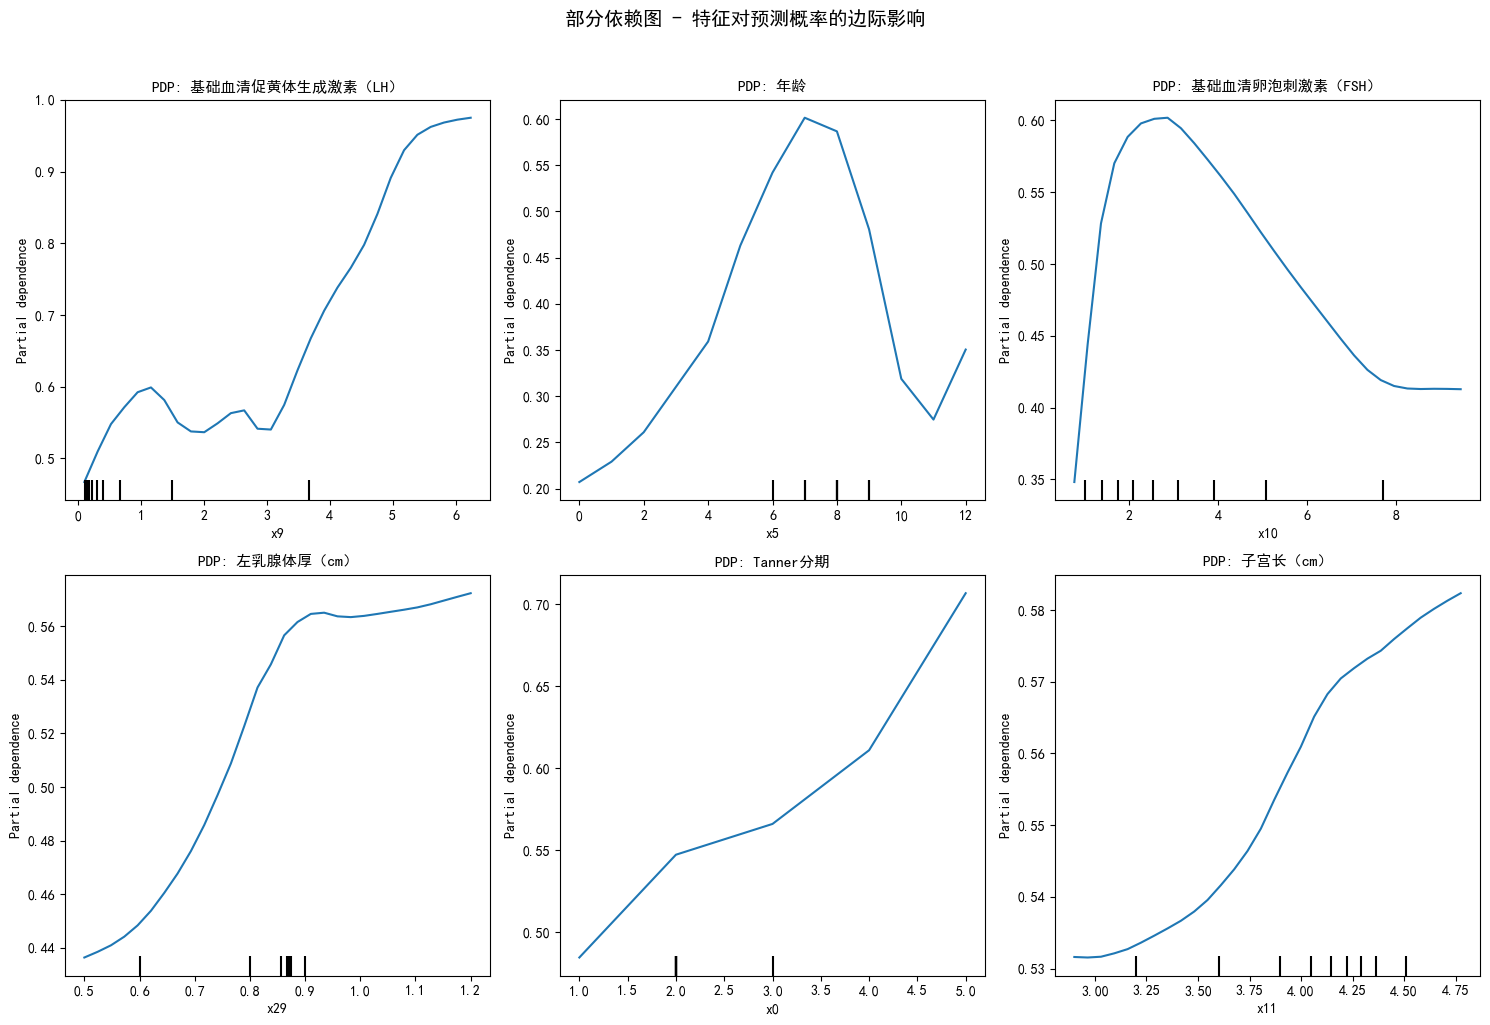


PDP分析完成！
已保存: ./output/tabpfn_enhanced/PDP_top_features.png


In [35]:
print("=" * 70)
print("PDP部分依赖图分析 (tabpfn-extensions 0.2.2新功能)")
print("=" * 70)

from tabpfn_extensions.interpretability.pdp import partial_dependence_plots

# 选择最重要的特征进行PDP分析
top_features = feature_importance.head(6)["特征"].tolist()
top_feature_indices = [feature_cols_processed.index(f) for f in top_features]

print(f"分析前6个最重要特征: {top_features}")

# 使用部分验证集样本进行PDP分析
n_pdp_samples = min(500, len(X_validation_processed))
X_pdp = X_validation_processed[:n_pdp_samples]

# 为每个重要特征生成PDP图
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (feature_idx, feature_name) in enumerate(
    zip(top_feature_indices, top_features)
):
    print(f"  生成 {feature_name} 的PDP图...")
    ax = axes[idx]

    try:
        disp = partial_dependence_plots(
            estimator=tabpfn_basic,
            X=X_pdp,
            features=[feature_idx],
            kind="average",
            target_class=1,  # 正类（早熟）
            ax=ax,
            grid_resolution=30,
        )
        ax.set_title(f"PDP: {feature_name}", fontsize=11, fontweight="bold")
        ax.set_xlabel(feature_name, fontsize=10)
        ax.set_ylabel("部分依赖", fontsize=10)
        ax.grid(alpha=0.3)
    except Exception as e:
        ax.text(0.5, 0.5, f"Error: {str(e)[:30]}...", ha="center", va="center")
        ax.set_title(f"PDP: {feature_name} (错误)", fontsize=11)

plt.suptitle(
    "部分依赖图 - 特征对预测概率的边际影响", fontsize=14, fontweight="bold", y=1.02
)
plt.tight_layout()
plt.savefig(
    "./output/tabpfn_enhanced/PDP_top_features.png", dpi=300, bbox_inches="tight"
)
plt.savefig(
    "./output/tabpfn_enhanced/PDP_top_features.pdf", dpi=300, bbox_inches="tight"
)
plt.show()

print("\nPDP分析完成！")
print("已保存: ./output/tabpfn_enhanced/PDP_top_features.png")